In [52]:
import os
import numpy as np

from keras.layers import Dense, Input, Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose

from keras.models import Model
from keras import backend as K

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from keras.datasets import cifar10
from keras.utils import plot_model

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [45]:
# Define a func to get a gray-scale image
def get_gray(data):
    return data[..., :3].dot([.299, .587, .114]) 

In [47]:
def normalize_it(images):
    return images.astype('float32') / 255

# Colouring autoencoder with Keras

## Load, examine & transform the data

In [92]:
(X_train, _), (X_test, _) = cifar10.load_data()

In [93]:
# Check dimensions
X_train.shape

(50000, 32, 32, 3)

In [94]:
# X_train = X_train[:25000]

In [95]:
# Get dimensions
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
channels = X_train.shape[3]

* ### Convert imgs to grayscale

In [96]:
X_train_gray = get_gray(X_train)
X_test_gray = get_gray(X_test)

MemoryError: 

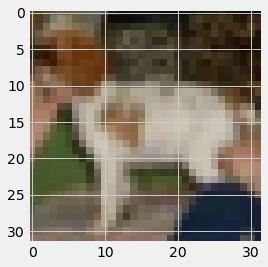

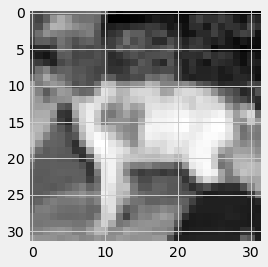

In [43]:

plt.imshow(X_test[12].squeeze())
plt.show()

plt.imshow(X_test_gray[12].squeeze(), 
           cmap = 'gray')
plt.show()

In [48]:
# Normalize the data
X_train = normalize_it(X_train)
X_test = normalize_it(X_test)

In [88]:
# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 
                          img_rows, 
                          img_cols, 
                          channels)

X_test = X_test.reshape(X_test.shape[0], 
                          img_rows, 
                          img_cols, 
                          channels)

X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], 
                                    img_rows, 
                                    img_cols, 
                                    channels)

X_test_gray = X_test_gray.reshape(X_test_gray.shape[0], 
                                  img_rows, 
                                  img_cols, 
                                  channels)

ValueError: cannot reshape array of size 25600000 into shape (25000,32,32,3)

## Define network params

In [53]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

## Build the model

* ### Encoder

In [54]:
inputs = Input(shape = input_shape, 
               name  = 'encoder_input')

x = inputs

In [55]:
# Create a stack of Conv2Ds

for filters in layer_filters:
    x = Conv2D(filters     = filters,
               kernel_size = kernel_size,
               strides     = 2, 
               activation  = 'relu',
               padding     = 'same')(x)

In [56]:
# Get the last layer's shape
enc_out_shape = K.int_shape(x)

In [57]:
# Create a latent vector
x = Flatten()(x)

latent = Dense(latent_dim, 
               name = 'latent_vector')(x)

In [58]:
# Instantiate the encoder
encoder = Model(inputs, latent,
                name = 'encoder')

In [59]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________________________


* ### Decoder

In [60]:
latent_inputs = Input(shape = (latent_dim,), 
                      name  = 'decoder_input')

In [61]:
x = Dense(enc_out_shape[1] * enc_out_shape[2] * enc_out_shape[3])(latent_inputs)

x = Reshape((enc_out_shape[1], 
             enc_out_shape[2], 
             enc_out_shape[3]))(x)

In [63]:
# Construct a stack of Conv2DTranspose
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters     = filters, 
                        kernel_size = kernel_size,
                        strides     = 2,
                        activation  = 'relu', 
                        padding     = 'same')(x)

In [64]:
outputs = Conv2DTranspose(filters     = channels, 
                          kernel_size = kernel_size,
                          activation  = 'sigmoid', 
                          padding     = 'same', 
                          name        = 'decoder_output')(x)

In [68]:
# Instantiate the decoder
decoder = Model(latent_inputs, outputs,
                name = 'decoder')

In [69]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731      
Total para

* ### Autoencoder

In [70]:
# Instantiate
autoencoder = Model(inputs, decoder(encoder(inputs)),
                    name = 'autoencoder')

In [71]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


* ### Model saving params

In [79]:
# Define file names / dirs
save_dir = '03_saved_models'
model_name = 'colorizer_ae_{epoch:03d}.h5'

In [80]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

* ### Define callbacks

In [81]:
# Reduce LR by sqrt(.1) if loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor   = np.sqrt(.1), 
                               cooldown = 0,
                               patience = 5,
                               verbose  = 1, 
                               min_lr   = 0.5e-6)

In [67]:
# Save chackpoint
checkpoint = ModelCheckpoint(filepath       = filepath, 
                             monitor        = 'val_loss',
                             verbose        = 1,
                             save_best_only = True)

* ### Compile & train the model 

In [82]:
# Compile 
autoencoder.compile(loss      = 'mse',
                    optimizer = 'adam')

In [85]:
# Define callbacks
callbacks = [lr_reducer, checkpoint]

In [86]:
# Train
autoencoder.fit(X_train_gray, X_train,
                validation_data = (X_test_gray, X_test),
                epochs          = 3,
                batch_size      = batch_size,
                callbacks       = callbacks)

ValueError: Error when checking input: expected encoder_input to have 4 dimensions, but got array with shape (25000, 32, 32)